In [1]:
import dlib
import cv2 as cv
from tqdm import tqdm
from tqdm import tnrange
import numpy as np
from IPython.display import Image


In [2]:
pNum = "T000001"

proj = "/root/proj/SecurityAI_Round1"
pimg = f"{proj}/Data/images"
pmdl = f"{proj}/Model"
pout = f"{proj}/Out/{pNum}"

In [3]:
modelv = "_68"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(f"{pmdl}/shape_predictor{modelv}_face_landmarks.dat")

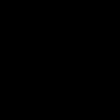

In [4]:
op = f"{proj}/Data/X.jpg"
iii = np.random.randint(0, 1, size=(112, 112, 3))
iii[:] = [0, 0, 0]
cv.imwrite(op, iii)
Image(filename=op, width=300, height=300)


In [5]:
# st, ed = 1, 100
st, ed = 1, 712


In [6]:
def f_xy(images):
    result = []
    cv_face = detector(cv.cvtColor(images, cv.COLOR_BGR2GRAY), 1)
    for face in cv_face:
        shape = predictor(images, face)
        for pt in shape.parts():
            result.append((pt.y, pt.x))
    return result

print(
    len(f_xy(cv.imread(f"{pimg}/00001.jpg"))), 
    len(f_xy(cv.imread(f"{pimg}/00003.jpg")))
)
%time len(f_xy(cv.imread(f"{pimg}/00001.jpg")))


68 0
CPU times: user 14.7 ms, sys: 70 µs, total: 14.7 ms
Wall time: 14.4 ms


68

In [7]:
def f_lcos(f1, f2):
    df1 = [np.average(i) for i in f1]
    df2 = [np.average(i) for i in f2]
    return 1 - np.dot(df1/np.linalg.norm(df1, 2), df2/np.linalg.norm(df2, 2))

print("SAME:%.6f" % f_lcos(cv.imread(f"{pimg}/00001.jpg"), cv.imread(f"{pimg}/00001.jpg")))
print("DIFF:%.6f" % f_lcos(cv.imread(f"{pimg}/00001.jpg"), cv.imread(f"{pimg}/00002.jpg")))
print("DIFF:%.6f" % f_lcos(cv.imread(f"{pimg}/00001.jpg"), cv.imread(f"{pimg}/00406.jpg")))

%time f_lcos(cv.imread(f"{pimg}/00001.jpg"), cv.imread(f"{pimg}/00002.jpg"))


SAME:0.000000
DIFF:0.073383
DIFF:0.004231
CPU times: user 2.01 ms, sys: 906 µs, total: 2.91 ms
Wall time: 2.86 ms


0.07338285522785237

In [8]:
def f_lf1(f1, f2):
    return np.sqrt(np.sum(np.square(f1 - f2)))

print("SAME:%.6f" % f_lf1(cv.imread(f"{pimg}/00001.jpg"), cv.imread(f"{pimg}/00001.jpg")))
print("DIFF:%.6f" % f_lf1(cv.imread(f"{pimg}/00001.jpg"), cv.imread(f"{pimg}/00002.jpg")))
print("DIFF:%.6f" % f_lf1(cv.imread(f"{pimg}/00001.jpg"), cv.imread(f"{pimg}/00406.jpg")))

%time f_lf1(cv.imread(f"{pimg}/00001.jpg"), cv.imread(f"{pimg}/00002.jpg"))


SAME:0.000000
DIFF:1974.158302
DIFF:1993.636627
CPU times: user 869 µs, sys: 0 ns, total: 869 µs
Wall time: 877 µs


1974.1583016566833

In [9]:
"""
简单思路
    1\根据L2距离找出最近人脸；
    2\根据clip限制M68取结果；
    # 是否可以考虑放大；
"""

def frun(tpath, time):
    n = 2
    
    for i in tnrange(st, ed+1, desc=f"{time}"):
        pi = f"{pimg}/"+f"00000{i}"[-5:]+".jpg"
        op = f"{pout}/images/"+f"00000{i}"[-5:]+".jpg"

        img = cv.imread(pi)
        imgj, min_p012 = 1, 99999.0

        for imgi in range(st, ed+1, 1):
            imgx = cv.imread(tpath+f"00000{imgi}"[-5:]+".jpg")
            p012 = f_lf1(img, imgx)

            if p012 < min_p012 and imgi != i:
                imgj, min_p012 = imgi, p012

        print(f"{i},{imgj}, Avg:{min_p012:.{6}}")
        
        img_o = img.copy()
        img_g = cv.imread(tpath+f"00000{imgj}"[-5:]+".jpg")
        # img_g = cv.imread(f"{proj}/Data/X.jpg")
        
        img_m68 = f_xy(img)
        if img_m68:
            yl, xl = [i[0] for i in img_m68], [i[1] for i in img_m68]
            min_yl, max_yl, min_xl, max_xl = min(yl), max(yl), min(xl), max(xl)
            print(min_yl, max_yl, min_xl, max_xl)
            
            img_o[min_yl:max_yl, min_xl:max_xl] = img_g[min_yl:max_yl, min_xl:max_xl]
        else:
            img_o = img_g
        
        img_o = np.clip(img_o, img-25.5, img+25.5)
        cv.imwrite(op, img_o)
        
frun(f"{pimg}/", 0)
# 1, 37.7798


1,679, Avg:1874.62
37 114 19 105
2,22, Avg:1844.85
38 113 14 103
3,318, Avg:1952.25
4,20, Avg:1910.31
38 114 -3 86
5,118, Avg:1911.88
36 113 24 104
6,245, Avg:1882.96
37 113 9 94
7,284, Avg:1932.02
8,675, Avg:1868.55
37 113 26 107
9,561, Avg:1890.75
39 115 27 116
10,219, Avg:1905.06
42 112 20 95
11,306, Avg:1910.19
40 113 25 107
12,160, Avg:1932.21
13,299, Avg:1924.5
39 114 19 97
14,523, Avg:1896.77
39 114 24 112
15,93, Avg:1899.68
40 115 24 114
16,664, Avg:1904.13
39 113 30 109
17,273, Avg:1890.84
40 116 13 94
18,101, Avg:1880.28
32 113 21 106
19,665, Avg:1874.47
38 113 5 89
20,487, Avg:1900.78
35 113 -1 86
21,30, Avg:1904.6
22,2, Avg:1844.85
40 112 19 97
23,600, Avg:1899.23
39 113 14 90
24,155, Avg:1916.31
39 114 5 90
25,665, Avg:1912.92
37 113 19 101
26,435, Avg:1929.15
37 114 18 89
27,626, Avg:1895.29
40 115 -2 82
28,23, Avg:1932.63
41 116 20 100
29,318, Avg:1927.85
39 112 6 90
30,61, Avg:1882.27
36 113 0 79
31,154, Avg:1940.12
37 114 14 108
32,261, Avg:1929.46
32 114 5 87
33,286, 

251,311, Avg:1887.84
39 116 24 104
252,167, Avg:1909.72
40 116 12 91
253,332, Avg:1856.84
42 112 21 96
254,140, Avg:1925.37
35 114 2 81
255,165, Avg:1912.33
36 115 16 93
256,69, Avg:1923.94
42 114 15 100
257,217, Avg:1918.57
40 114 9 99
258,455, Avg:1908.62
40 102 21 105
259,490, Avg:1929.77
39 113 26 108
260,93, Avg:1882.47
39 115 4 87
261,72, Avg:1846.51
35 114 -2 87
262,315, Avg:1906.04
40 112 9 89
263,278, Avg:1917.46
42 113 8 100
264,573, Avg:1873.97
39 113 26 110
265,564, Avg:1919.41
38 114 20 101
266,665, Avg:1926.78
42 115 15 91
267,294, Avg:1903.83
39 118 12 91
268,699, Avg:1877.95
42 114 27 108
269,96, Avg:1907.37
39 112 21 106
270,653, Avg:1924.13
35 112 9 87
271,261, Avg:1894.26
39 112 5 84
272,370, Avg:1909.86
34 115 16 93
273,17, Avg:1890.84
40 114 10 93
274,427, Avg:1901.85
40 117 30 111
275,121, Avg:1886.01
39 113 10 97
276,453, Avg:1881.93
37 117 11 96
277,679, Avg:1891.13
34 114 21 108
278,417, Avg:1883.82
40 113 7 100
279,679, Avg:1819.85
40 114 10 93
280,644, Avg:19

495,305, Avg:1886.58
40 114 17 101
496,332, Avg:1880.89
41 113 14 101
497,542, Avg:1881.0
41 114 10 92
498,271, Avg:1932.84
499,598, Avg:1935.41
38 115 19 97
500,646, Avg:1905.92
39 113 20 97
501,512, Avg:1909.48
39 116 17 95
502,426, Avg:1883.07
38 114 14 103
503,569, Avg:1941.72
34 116 10 86
504,301, Avg:1887.12
38 113 15 102
505,440, Avg:1838.92
37 113 12 96
506,163, Avg:1885.67
42 114 16 94
507,321, Avg:1949.64
40 113 13 93
508,104, Avg:1839.03
37 113 21 106
509,336, Avg:1914.22
36 114 28 105
510,478, Avg:1928.52
40 118 15 95
511,694, Avg:1944.79
38 115 0 93
512,281, Avg:1891.79
38 113 14 92
513,625, Avg:1900.81
38 113 23 108
514,681, Avg:1913.75
34 115 21 110
515,681, Avg:1894.43
41 113 17 97
516,436, Avg:1919.9
517,301, Avg:1913.08
40 115 13 89
518,187, Avg:1911.32
38 114 5 91
519,313, Avg:1925.78
40 115 13 99
520,22, Avg:1852.34
41 114 -3 87
521,594, Avg:1936.23
38 113 10 95
522,217, Avg:1911.01
45 113 16 92
523,14, Avg:1896.77
39 113 22 106
524,329, Avg:1786.94
33 116 32 114
52

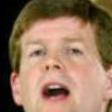

In [10]:
Image(filename=f"{pimg}/00001.jpg", width=300, height=300)

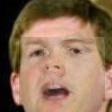

In [11]:
Image(filename=f"{pout}/images/00001.jpg", width=300, height=300)

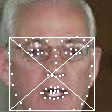

In [12]:
pi = f"{pimg}/"+f"00006.jpg"
op = f"{proj}/Data/Y.jpg"
img = cv.imread(pi)

min_x, min_y = 9999, 9999
max_x, max_y = -9999, -9999

for if_xy in f_xy(img):
    y, x = if_xy
    if 0 <= x < 112 and 0 <= y < 112:
        img[y-1:y+1, x-1:x+1] = 255
        
        min_y, min_x = min(min_y, y), min(min_x, x)
        max_y, max_x = max(max_y, y), max(max_x, x)

cv.line(img, (min_x, min_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (min_x, min_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (min_x, min_y), (max_x, min_y), (255, 255, 255))

cv.line(img, (min_x, max_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (min_x, max_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (min_x, max_y), (max_x, min_y), (255, 255, 255))

cv.line(img, (max_x, min_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (max_x, min_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (max_x, min_y), (max_x, min_y), (255, 255, 255))

cv.line(img, (max_x, max_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (max_x, max_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (max_x, max_y), (max_x, min_y), (255, 255, 255))

cv.imwrite(op, img)
Image(filename=op, width=300, height=300)


In [13]:
# cosin相似度（余弦相似度）
# https://blog.csdn.net/weixin_39121325/article/details/84187453

